In [86]:
# LIST OF UPDATES
#
# Added bias (constant) to each linear layer
# Switched to using equivalent keras optimizer - SGD 
# Moved loss calculation to an independent function
# Switched to defining the network as Keras layers(!)
# Add tf.function to training loop - 10x speed increase(!)
# Switch to calculating gradients with keras 'trainable_weight' vs tf 'variables' 
# Tried using Keras Model.fit but order of magnitude slower than custom loop!
# Switch to train/val/test -> Showed that validation accuracy peaks at about 55% Training accuracy :(
# Switch to MeanSquaredError as loss function (But this is not a good error for classification)
# Add callback support to custom training loop
# Early completion based on validation changes
# Switch to correct method of regularisation with L2 Loss
# Addition of Dropout for regularisation
# Batch support (improves regularisation)
# Tried various train/test/val combinations - results are very sensitive to this.
# Tried various activation functions - "elu" seems best (not sure why yet)
# Switched to BinaryCrossEntropy loss function from keras
# Switched to Adam optimiser with scheduled learning
# Utilised log x-scale to compare model plot results
# Switch to "relu" activation function on hidden nodes - good for variables in 0 to 1 range.
# Add Accuracy as a metric
# Add multiple plots to compare metrics
# Switch to Hinge loss function- better for penalising wrong sign!
# Switch to tanh activation function and -1/1 labels (for Hinge)
# Initialise variables with "he-uniform" - better for relu?
# Regularisation after the activiation function, using Lamda to control how much impact.
# TODO : Represent data using windowing method


In [3]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1

import numpy as np
import pandas as pd
import time

import quantutils.dataset.pipeline as ppl
import quantutils.dataset.ml as mlutils
from marketinsights.api.model import MarketInsightsModel
from marketinsights.remote.ml import MIAssembly

from tqdm import tqdm, trange
from functools import partialmethod

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt


tqdm.__init__ = partialmethod(tqdm.__init__, disable=False)

In [226]:
#DATASET_ID1 = "dbaab93d94795145539e595fab79f2d4"  # DOW
#DATASET_ID1 = "4234f0f1b6fcc17f6458696a6cdf5101"  # DOW
DATASET_ID1 = "09dcbc101dd03d999a479baa924901b3" # 2023 - Corrected 
#DATASET_ID1 = "1f0ee1144486054fa56d65ce71b04110" # 2023 - Corrected 
NUM_FEATURES = (2 * 4) + 1

assembly = MIAssembly(secret="marketinsights-k8s-cred")

# Dataset
dataset, descriptor = assembly.get_dataset_by_id(DATASET_ID1, debug=False)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1387 entries, 2013-01-02 15:00:00-05:00 to 2018-08-01 15:00:00-04:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1387 non-null   float64
 1   1       1387 non-null   float64
 2   2       1387 non-null   float64
 3   3       1387 non-null   float64
 4   4       1387 non-null   float64
 5   5       1387 non-null   float64
 6   6       1387 non-null   float64
 7   7       1387 non-null   float64
 8   8       1387 non-null   float64
 9   9       1387 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 119.2 KB


In [227]:
# Flip labels for Hinge loss function
labels = dataset[9]
labels[labels == 0] = -1
dataset[9] = labels
dataset

,0,1,2,3,4,5,6,7,8,9
Date_Time,,,,,,,,,,
2013-01-02 15:00:00-05:00,0.390854,0.826284,0.199852,0.508756,0.504133,1.000000,0.000000,0.629408,0.051259,1
2013-01-03 15:00:00-05:00,0.766445,1.000000,0.586159,0.943148,0.943148,0.944016,0.000000,0.487062,0.108321,-1
2013-01-04 15:00:00-05:00,0.096991,1.000000,0.000000,0.631825,0.632902,0.905283,0.340489,0.847693,0.043706,1
2013-01-07 15:00:00-05:00,0.078908,0.468290,0.000000,0.337985,0.337655,1.000000,0.253843,0.984516,0.071635,1
2013-01-08 15:00:00-05:00,0.000000,0.748026,0.000000,0.685708,0.685012,1.000000,0.344723,0.518904,0.068146,1
...,...,...,...,...,...,...,...,...,...,...
2018-07-26 15:00:00-04:00,0.117785,0.779641,0.000000,0.500333,0.492980,1.000000,0.345889,0.654713,0.078719,-1
2018-07-27 15:00:00-04:00,0.378094,0.888481,0.000000,0.861922,0.845986,1.000000,0.287613,0.489824,0.109395,1
2018-07-30 15:00:00-04:00,0.307187,0.954621,0.000000,0.892212,0.903560,1.000000,0.369722,0.483388,0.102674,-1


In [228]:
dataset.insert(4, "3.5", dataset[8].values)

In [237]:
features = (np.reshape(dataset.loc[:,:8].values, (len(dataset),2,5)) * 2.0) - 1

In [238]:
labels = np.reshape(dataset[9].values, (len(dataset),1,1))

In [239]:
ds = tf.data.Dataset.from_tensor_slices((features, labels))

In [240]:
all_x, all_y = dataset_to_tensor(ds.skip(1200).batch(40))

In [241]:
all_x.shape

TensorShape([187, 2, 5])

In [242]:
train_ds = ds.take(1200).batch(40)
val_ds = ds.skip(1200).take(100).batch(100)
test_ds = ds.skip(1300).take(100).batch(100)

In [243]:
train_df_x, train_df_y = dataset_to_tensor(train_ds)
val_df_x, val_df_y = dataset_to_tensor(val_ds)
test_df_x, test_df_y = dataset_to_tensor(test_ds)

In [244]:
train_df_x

<tf.Tensor: shape=(1200, 2, 5), dtype=float32, numpy=
array([[[-0.21829142,  0.6525677 , -0.6002953 ,  0.01751144,
         -0.89748204],
        [ 0.00826512,  1.        , -1.        ,  0.2588159 ,
         -0.89748204]],

       [[ 0.5328901 ,  1.        ,  0.17231701,  0.8862958 ,
         -0.7833588 ],
        [ 0.8862958 ,  0.8880319 , -1.        , -0.02587597,
         -0.7833588 ]],

       [[-0.8060177 ,  1.        , -1.        ,  0.26365003,
         -0.91258764],
        [ 0.26580366,  0.8105657 , -0.31902137,  0.6953861 ,
         -0.91258764]],

       ...,

       [[-0.7239906 ,  1.        , -1.        ,  0.48299602,
         -0.92615074],
        [ 0.4485232 ,  0.6553491 , -0.44802845, -0.31006503,
         -0.92615074]],

       [[-0.06215989,  0.37529337, -1.        ,  0.06284009,
         -0.9185584 ],
        [ 0.12533608,  1.        , -0.24967986,  0.06284009,
         -0.9185584 ]],

       [[-0.27975342,  1.        , -1.        , -0.5198048 ,
         -0.93616796],

In [95]:
def roundTan(x):
    x = tf.where(x < 0, -1., x)
    x = tf.where(x > 0, 1., x)
    return x

def toSigmoid(x):
    return tf.where(x<0, 0., 1.)

def dataset_to_tensor(dataset):
    # Create an empty list to store the numpy arrays
    x = []
    y = []
    
    # Loop through the mapdataset
    for element in dataset:
        # Convert the element to a numpy array and append it to the list
        x.append(element[0].numpy())
        y.append(element[1].numpy())
    
    # Return the list of numpy arrays
    return tf.cast(np.concatenate(x, axis=0), tf.float32), tf.cast(np.concatenate(y, axis=0), tf.float32)


def train(mlmodel, epochs=100000, _callbacks=[]):
    
    callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=True, model=mlmodel)
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001,
      decay_steps=1000,
      decay_rate=1,
      staircase=False)

    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SquaredHinge()
    val_loss_fn = tf.keras.metrics.SquaredHinge()
    metric = tf.keras.losses.MeanSquaredError()
    accuracyMetric = tf.keras.metrics.Accuracy()
    val_accuracyMetric = tf.keras.metrics.Accuracy()
    lamda = tf.constant(0.1, tf.float32)
    
    
    @tf.function  # Make it fast.
    def train_on_batch(x, y):
        with tf.GradientTape() as tape:
                        
            loss = loss_fn(y_pred=tf.nn.tanh(mlmodel(x, training=True)), y_true=y) 
            regularization_loss=tf.add_n(mlmodel.losses)
            loss = loss + regularization_loss * lamda
            
            #binary_cross_entropy = metric(y_pred=y_pred, y_true=y) 
            val_model = tf.nn.tanh(mlmodel(val_df_x))
            
            #val_binary_cross_entropy = metric(y_pred=val_y_pred, y_true=val_y)
            val_loss = val_loss_fn(y_pred=val_model, y_true=val_df_y) 
            
            accuracy = accuracyMetric(y_pred=roundTan(mlmodel(x)), y_true=y)
            val_accuracy = val_accuracyMetric(y_pred=roundTan(val_model), y_true=val_df_y)
            
            gradients = tape.gradient(loss, mlmodel.trainable_weights)
        optimizer.apply_gradients(zip(gradients, mlmodel.trainable_weights))
        return {
            "loss":loss, 
            "val_loss": val_loss, 
            #"metric":binary_cross_entropy, 
            #"val_metric":val_binary_cross_entropy, 
            "accuracy": accuracy,
            "val_accuracy": val_accuracy,
            "regularization_loss":regularization_loss}


    logs = {}
    mlmodel.stop_training = False

    # Store the start time
    start_time = time.time()
    
    callbacks.on_train_begin(logs=logs)

    # Format training loop
    for epoch in range(epochs):

        callbacks.on_epoch_begin(epoch, logs=logs)
        #mlmodel.reset_states() # Not needed?

        for batch, (batch_x, batch_y) in enumerate(train_ds):

            callbacks.on_batch_begin(batch, logs=logs)
            callbacks.on_train_batch_begin(batch, logs=logs)

            logs = train_on_batch(batch_x, batch_y)

            callbacks.on_train_batch_end(batch, logs=logs)
            callbacks.on_batch_end(batch, logs=logs)

        callbacks.on_epoch_end(epoch, logs=logs)

        if epoch % 100 == 0:
            
            # Store the end time
            end_time = time.time() - start_time
            start_time = time.time()
            
            print(f'Step {epoch} - Training Loss: {logs["loss"]}, Val Loss: {logs["val_loss"]}, Accuracy: {logs["accuracy"]}, Val Accuracy: {logs["val_accuracy"]}, Time: {end_time:.2f} sec')

        if mlmodel.stop_training:
            print(f'Step {epoch} - Training Loss: {logs["loss"]}, Val Loss: {logs["val_loss"]}')
            break

    callbacks.on_train_end(logs=logs)

    # Fetch the history object we normally get from keras.fit
    history_object = None
    for cb in callbacks:
        if isinstance(cb, tf.keras.callbacks.History):
            history_object = cb
    assert history_object is not None
    
    return history_object

In [98]:
TOTAL_EPOCHS = 200000

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, start_from_epoch=500, patience=10000, restore_best_weights=True)
# Set up callbacks
callbacks = [earlyStopping]


In [99]:
histories = {}

In [ ]:
NUM_LABELS = 1
HIDDEN_UNITS = 64

conv_layer = tf.keras.layers.Conv1D(
            filters=HIDDEN_UNITS,
            kernel_size=(2,),
            kernel_initializer='he_uniform',
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
            activation='relu')

# Prepare our layer, loss, and optimizer.
mlmodel = tf.keras.Sequential(
    [
        # Shape: (time, features) => (time*features)
        conv_layer,
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dense(NUM_LABELS),
    ]
)

histories["64x4"] = train(mlmodel, TOTAL_EPOCHS, callbacks)

In [101]:
NUM_LABELS = 1
HIDDEN_UNITS = 512

conv_layer = tf.keras.layers.Conv1D(
            filters=HIDDEN_UNITS,
            kernel_size=(2,),
            kernel_initializer='he_uniform',
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
            activation='relu')

# Prepare our layer, loss, and optimizer.
mlmodel = tf.keras.Sequential(
    [
        # Shape: (time, features) => (time*features)
        conv_layer,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.8),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_LABELS),
    ]
)

history = train(mlmodel, TOTAL_EPOCHS, callbacks)

print("Done")

Step 0 - Training Loss: 1.4128813743591309, Val Loss: 1.7471652030944824, Accuracy: 0.5016666650772095, Val Accuracy: 0.49266666173934937, Time: 2.91 sec
Step 100 - Training Loss: 1.569186806678772, Val Loss: 2.0907607078552246, Accuracy: 0.5271204710006714, Val Accuracy: 0.4748019874095917, Time: 26.14 sec
Step 200 - Training Loss: 1.4446502923965454, Val Loss: 2.044947624206543, Accuracy: 0.5248051285743713, Val Accuracy: 0.4874991774559021, Time: 25.90 sec
Step 300 - Training Loss: 1.3144476413726807, Val Loss: 2.030014753341675, Accuracy: 0.5240393280982971, Val Accuracy: 0.4916522800922394, Time: 27.64 sec
Step 400 - Training Loss: 1.231623649597168, Val Loss: 2.0225298404693604, Accuracy: 0.5236554741859436, Val Accuracy: 0.4937340021133423, Time: 26.93 sec
Step 500 - Training Loss: 1.2533795833587646, Val Loss: 2.017914056777954, Accuracy: 0.5149734020233154, Val Accuracy: 0.4949920177459717, Time: 27.67 sec
Step 600 - Training Loss: 2.7837541103363037, Val Loss: 2.0035142898559

Step 5300 - Training Loss: 1.7809243202209473, Val Loss: 2.06623911857605, Accuracy: 0.523080050945282, Val Accuracy: 0.48331648111343384, Time: 25.16 sec
Step 5400 - Training Loss: 2.1341006755828857, Val Loss: 2.070960283279419, Accuracy: 0.5231185555458069, Val Accuracy: 0.48213744163513184, Time: 26.25 sec
Step 5500 - Training Loss: 1.477333426475525, Val Loss: 2.07253360748291, Accuracy: 0.523141086101532, Val Accuracy: 0.48174288868904114, Time: 26.00 sec
Step 5600 - Training Loss: 1.4906220436096191, Val Loss: 2.0749170780181885, Accuracy: 0.5231845378875732, Val Accuracy: 0.48114556074142456, Time: 24.73 sec
Step 5700 - Training Loss: 1.276725172996521, Val Loss: 2.075991630554199, Accuracy: 0.5231435894966125, Val Accuracy: 0.4808770418167114, Time: 25.40 sec
Step 5800 - Training Loss: 1.310171365737915, Val Loss: 2.076775074005127, Accuracy: 0.5230368375778198, Val Accuracy: 0.48068246245384216, Time: 25.75 sec
Step 5900 - Training Loss: 1.0835024118423462, Val Loss: 2.072050

Step 10600 - Training Loss: 0.959322988986969, Val Loss: 1.5967944860458374, Accuracy: 0.5400885939598083, Val Accuracy: 0.5053096413612366, Time: 25.39 sec
Step 10700 - Training Loss: 0.8980516195297241, Val Loss: 1.5912175178527832, Accuracy: 0.5404479503631592, Val Accuracy: 0.5056734681129456, Time: 26.76 sec
Step 10800 - Training Loss: 0.9838892221450806, Val Loss: 1.58574378490448, Accuracy: 0.5408077239990234, Val Accuracy: 0.5060162544250488, Time: 27.26 sec
Step 10900 - Training Loss: 0.9678964614868164, Val Loss: 1.580370545387268, Accuracy: 0.5411508083343506, Val Accuracy: 0.506312370300293, Time: 27.65 sec
Step 11000 - Training Loss: 1.0597370862960815, Val Loss: 1.5750948190689087, Accuracy: 0.5415011048316956, Val Accuracy: 0.5065907835960388, Time: 26.92 sec
Step 11100 - Training Loss: 0.931010901927948, Val Loss: 1.5699143409729004, Accuracy: 0.5418481230735779, Val Accuracy: 0.5069180727005005, Time: 26.48 sec
Step 11200 - Training Loss: 0.9318222403526306, Val Loss: 

Step 15900 - Training Loss: 0.9793992042541504, Val Loss: 1.3978618383407593, Accuracy: 0.5523133873939514, Val Accuracy: 0.516116201877594, Time: 33.21 sec
Step 16000 - Training Loss: 0.948866069316864, Val Loss: 1.395375370979309, Accuracy: 0.5524501800537109, Val Accuracy: 0.5162891745567322, Time: 33.59 sec
Step 16100 - Training Loss: 0.9259026646614075, Val Loss: 1.3927762508392334, Accuracy: 0.5525863170623779, Val Accuracy: 0.5164667367935181, Time: 34.05 sec
Step 16200 - Training Loss: 0.9413063526153564, Val Loss: 1.3901461362838745, Accuracy: 0.5527216196060181, Val Accuracy: 0.5166378021240234, Time: 33.09 sec
Step 16300 - Training Loss: 1.002831220626831, Val Loss: 1.3875141143798828, Accuracy: 0.5528481006622314, Val Accuracy: 0.5168536305427551, Time: 33.10 sec
Step 16400 - Training Loss: 0.9737650156021118, Val Loss: 1.3850101232528687, Accuracy: 0.5529791712760925, Val Accuracy: 0.5169628858566284, Time: 33.91 sec
Step 16500 - Training Loss: 0.9636158347129822, Val Loss

Step 21200 - Training Loss: 1.0080476999282837, Val Loss: 1.2902730703353882, Accuracy: 0.5579460263252258, Val Accuracy: 0.522670567035675, Time: 28.15 sec
Step 21300 - Training Loss: 0.9322990775108337, Val Loss: 1.2887386083602905, Accuracy: 0.5580172538757324, Val Accuracy: 0.5227648019790649, Time: 27.59 sec
Step 21400 - Training Loss: 0.9210122227668762, Val Loss: 1.287214756011963, Accuracy: 0.558103621006012, Val Accuracy: 0.5228488445281982, Time: 28.60 sec
Step 21500 - Training Loss: 0.9777243137359619, Val Loss: 1.2856959104537964, Accuracy: 0.5581836700439453, Val Accuracy: 0.5229693055152893, Time: 27.99 sec
Step 21600 - Training Loss: 0.9355846643447876, Val Loss: 1.2841880321502686, Accuracy: 0.5582623481750488, Val Accuracy: 0.5231232047080994, Time: 28.29 sec
Step 21700 - Training Loss: 0.9957861304283142, Val Loss: 1.2827129364013672, Accuracy: 0.5583327412605286, Val Accuracy: 0.5232357382774353, Time: 29.37 sec
Step 21800 - Training Loss: 0.9363264441490173, Val Los

Step 26500 - Training Loss: 0.9797714948654175, Val Loss: 1.2333505153656006, Accuracy: 0.5613670945167542, Val Accuracy: 0.5302581191062927, Time: 35.33 sec
Step 26600 - Training Loss: 0.9294916391372681, Val Loss: 1.2325496673583984, Accuracy: 0.5614163875579834, Val Accuracy: 0.5303751826286316, Time: 37.03 sec
Step 26700 - Training Loss: 0.9672417640686035, Val Loss: 1.2317310571670532, Accuracy: 0.561487078666687, Val Accuracy: 0.5304515957832336, Time: 32.05 sec
Step 26800 - Training Loss: 0.9793763160705566, Val Loss: 1.2308995723724365, Accuracy: 0.561549723148346, Val Accuracy: 0.5305850505828857, Time: 29.46 sec
Step 26900 - Training Loss: 0.9298467040061951, Val Loss: 1.230088710784912, Accuracy: 0.5616089701652527, Val Accuracy: 0.5307413339614868, Time: 29.53 sec
Step 27000 - Training Loss: 0.9447996020317078, Val Loss: 1.2292910814285278, Accuracy: 0.5616636276245117, Val Accuracy: 0.5308849215507507, Time: 28.66 sec
Step 27100 - Training Loss: 0.9263113141059875, Val Los

Step 31800 - Training Loss: 0.9820702075958252, Val Loss: 1.19655179977417, Accuracy: 0.5637006163597107, Val Accuracy: 0.5360774397850037, Time: 26.59 sec
Step 31900 - Training Loss: 0.9455766677856445, Val Loss: 1.1959677934646606, Accuracy: 0.5637431144714355, Val Accuracy: 0.5361689925193787, Time: 27.16 sec
Step 32000 - Training Loss: 0.9866363406181335, Val Loss: 1.1954143047332764, Accuracy: 0.5637810230255127, Val Accuracy: 0.5362637639045715, Time: 26.56 sec
Step 32100 - Training Loss: 0.9955801367759705, Val Loss: 1.1948541402816772, Accuracy: 0.563805878162384, Val Accuracy: 0.5363281965255737, Time: 26.12 sec
Step 32200 - Training Loss: 0.9689653515815735, Val Loss: 1.1943258047103882, Accuracy: 0.5638439655303955, Val Accuracy: 0.5363954901695251, Time: 26.74 sec
Step 32300 - Training Loss: 0.9289356470108032, Val Loss: 1.1937428712844849, Accuracy: 0.56387859582901, Val Accuracy: 0.5365104079246521, Time: 26.66 sec
Step 32400 - Training Loss: 0.9761534929275513, Val Loss:

Step 37100 - Training Loss: 0.9207532405853271, Val Loss: 1.17061448097229, Accuracy: 0.565101146697998, Val Accuracy: 0.5395623445510864, Time: 25.92 sec
Step 37200 - Training Loss: 0.9443327784538269, Val Loss: 1.1702003479003906, Accuracy: 0.5651256442070007, Val Accuracy: 0.5396157503128052, Time: 25.87 sec
Step 37300 - Training Loss: 0.9478700757026672, Val Loss: 1.1698873043060303, Accuracy: 0.5651510953903198, Val Accuracy: 0.5396372079849243, Time: 25.84 sec
Step 37400 - Training Loss: 0.9839963912963867, Val Loss: 1.1695349216461182, Accuracy: 0.5651739239692688, Val Accuracy: 0.5396655201911926, Time: 25.88 sec
Step 37500 - Training Loss: 0.9660111665725708, Val Loss: 1.1691062450408936, Accuracy: 0.565203070640564, Val Accuracy: 0.5397531986236572, Time: 26.46 sec
Step 37600 - Training Loss: 0.963981568813324, Val Loss: 1.1686683893203735, Accuracy: 0.5652318000793457, Val Accuracy: 0.5398126840591431, Time: 26.95 sec
Step 37700 - Training Loss: 0.9677571058273315, Val Loss:

Step 42400 - Training Loss: 0.9376758933067322, Val Loss: 1.150708794593811, Accuracy: 0.5660673379898071, Val Accuracy: 0.5411915183067322, Time: 26.61 sec
Step 42500 - Training Loss: 0.9874077439308167, Val Loss: 1.1503617763519287, Accuracy: 0.5660818219184875, Val Accuracy: 0.5412551760673523, Time: 26.45 sec
Step 42600 - Training Loss: 0.9664528965950012, Val Loss: 1.1500163078308105, Accuracy: 0.5660977363586426, Val Accuracy: 0.5413023233413696, Time: 26.13 sec
Step 42700 - Training Loss: 0.9807676076889038, Val Loss: 1.149672508239746, Accuracy: 0.5661173462867737, Val Accuracy: 0.5413455367088318, Time: 26.45 sec
Step 42800 - Training Loss: 0.9360988736152649, Val Loss: 1.1493302583694458, Accuracy: 0.5661218762397766, Val Accuracy: 0.5413900017738342, Time: 26.70 sec
Step 42900 - Training Loss: 0.9551201462745667, Val Loss: 1.1489896774291992, Accuracy: 0.5661220550537109, Val Accuracy: 0.5414490699768066, Time: 26.51 sec
Step 43000 - Training Loss: 1.0020283460617065, Val Lo

Step 47700 - Training Loss: 0.9899172782897949, Val Loss: 1.1342846155166626, Accuracy: 0.5668771266937256, Val Accuracy: 0.5395318865776062, Time: 25.27 sec
Step 47800 - Training Loss: 0.9370957016944885, Val Loss: 1.1340090036392212, Accuracy: 0.5668838620185852, Val Accuracy: 0.5394960045814514, Time: 25.22 sec
Step 47900 - Training Loss: 0.9470220804214478, Val Loss: 1.1337345838546753, Accuracy: 0.566889762878418, Val Accuracy: 0.5394469499588013, Time: 25.70 sec
Step 48000 - Training Loss: 0.9812646508216858, Val Loss: 1.133461356163025, Accuracy: 0.566904604434967, Val Accuracy: 0.539382815361023, Time: 25.44 sec
Step 48100 - Training Loss: 0.9607893824577332, Val Loss: 1.1331892013549805, Accuracy: 0.5669175386428833, Val Accuracy: 0.5393521189689636, Time: 25.16 sec
Step 48200 - Training Loss: 0.9716461896896362, Val Loss: 1.132918119430542, Accuracy: 0.5669304728507996, Val Accuracy: 0.5393334627151489, Time: 25.46 sec
Step 48300 - Training Loss: 0.9224730730056763, Val Loss:

Step 53000 - Training Loss: 1.0178673267364502, Val Loss: 1.1210885047912598, Accuracy: 0.5673811435699463, Val Accuracy: 0.5375341773033142, Time: 30.94 sec
Step 53100 - Training Loss: 0.9377695322036743, Val Loss: 1.1208643913269043, Accuracy: 0.5673831701278687, Val Accuracy: 0.5375365018844604, Time: 30.75 sec
Step 53200 - Training Loss: 0.9641565680503845, Val Loss: 1.1206411123275757, Accuracy: 0.5673863887786865, Val Accuracy: 0.5375231504440308, Time: 30.80 sec
Step 53300 - Training Loss: 0.9385672807693481, Val Loss: 1.120418667793274, Accuracy: 0.5673930644989014, Val Accuracy: 0.5374901294708252, Time: 31.01 sec
Step 53400 - Training Loss: 0.9339967370033264, Val Loss: 1.120197057723999, Accuracy: 0.5674065351486206, Val Accuracy: 0.5375204086303711, Time: 31.04 sec
Step 53500 - Training Loss: 0.976984977722168, Val Loss: 1.1199761629104614, Accuracy: 0.567416787147522, Val Accuracy: 0.5374694466590881, Time: 30.98 sec
Step 53600 - Training Loss: 0.9620378613471985, Val Loss

Step 58300 - Training Loss: 0.9312503337860107, Val Loss: 1.1102538108825684, Accuracy: 0.5677480101585388, Val Accuracy: 0.5371119379997253, Time: 26.76 sec
Step 58400 - Training Loss: 0.9823417067527771, Val Loss: 1.1100679636001587, Accuracy: 0.5677462816238403, Val Accuracy: 0.537169337272644, Time: 26.14 sec
Step 58500 - Training Loss: 0.9468596577644348, Val Loss: 1.1098828315734863, Accuracy: 0.5677515864372253, Val Accuracy: 0.5371743440628052, Time: 26.00 sec
Step 58600 - Training Loss: 1.0085538625717163, Val Loss: 1.1096981763839722, Accuracy: 0.5677586793899536, Val Accuracy: 0.5371533036231995, Time: 26.18 sec
Step 58700 - Training Loss: 0.9762323498725891, Val Loss: 1.1095142364501953, Accuracy: 0.5677628517150879, Val Accuracy: 0.5371226072311401, Time: 27.10 sec
Step 58800 - Training Loss: 0.9693577289581299, Val Loss: 1.1093308925628662, Accuracy: 0.5677745938301086, Val Accuracy: 0.5371297001838684, Time: 25.95 sec
Step 58900 - Training Loss: 0.937081515789032, Val Lo

Step 63600 - Training Loss: 0.9581876397132874, Val Loss: 1.1011987924575806, Accuracy: 0.567969024181366, Val Accuracy: 0.5372023582458496, Time: 25.70 sec
Step 63700 - Training Loss: 0.9446514248847961, Val Loss: 1.1010422706604004, Accuracy: 0.567968487739563, Val Accuracy: 0.5371852517127991, Time: 25.70 sec
Step 63800 - Training Loss: 0.9296765923500061, Val Loss: 1.1008862257003784, Accuracy: 0.5679683089256287, Val Accuracy: 0.5372143387794495, Time: 25.60 sec
Step 63900 - Training Loss: 0.95110684633255, Val Loss: 1.100730538368225, Accuracy: 0.5679753422737122, Val Accuracy: 0.537224292755127, Time: 25.37 sec
Step 64000 - Training Loss: 0.9827178120613098, Val Loss: 1.1005754470825195, Accuracy: 0.5679818987846375, Val Accuracy: 0.5371902585029602, Time: 25.73 sec
Step 64100 - Training Loss: 0.9832057356834412, Val Loss: 1.1004208326339722, Accuracy: 0.567978024482727, Val Accuracy: 0.5371786952018738, Time: 25.60 sec
Step 64200 - Training Loss: 0.9506491422653198, Val Loss: 1

Step 68900 - Training Loss: 0.9342302680015564, Val Loss: 1.0935183763504028, Accuracy: 0.5681661367416382, Val Accuracy: 0.5364965796470642, Time: 26.44 sec
Step 69000 - Training Loss: 0.9649488925933838, Val Loss: 1.0933846235275269, Accuracy: 0.5681639909744263, Val Accuracy: 0.536466121673584, Time: 26.53 sec
Step 69100 - Training Loss: 0.9316642880439758, Val Loss: 1.0932512283325195, Accuracy: 0.5681662559509277, Val Accuracy: 0.5364338159561157, Time: 26.62 sec
Step 69200 - Training Loss: 0.9928224086761475, Val Loss: 1.0931183099746704, Accuracy: 0.5681663751602173, Val Accuracy: 0.5364323854446411, Time: 26.85 sec
Step 69300 - Training Loss: 0.9568432569503784, Val Loss: 1.09298574924469, Accuracy: 0.568169891834259, Val Accuracy: 0.5364294052124023, Time: 26.26 sec
Step 69400 - Training Loss: 0.9260870814323425, Val Loss: 1.0928535461425781, Accuracy: 0.5681757926940918, Val Accuracy: 0.536421000957489, Time: 26.14 sec
Step 69500 - Training Loss: 0.9336926937103271, Val Loss:

Step 74200 - Training Loss: 0.9813990592956543, Val Loss: 1.0869214534759521, Accuracy: 0.5683354139328003, Val Accuracy: 0.5364364385604858, Time: 29.21 sec
Step 74300 - Training Loss: 0.9310081601142883, Val Loss: 1.086805820465088, Accuracy: 0.5683372616767883, Val Accuracy: 0.53644198179245, Time: 28.37 sec
Step 74400 - Training Loss: 0.9279798269271851, Val Loss: 1.0866906642913818, Accuracy: 0.5683424472808838, Val Accuracy: 0.5364415049552917, Time: 28.82 sec
Step 74500 - Training Loss: 0.9863569736480713, Val Loss: 1.0865757465362549, Accuracy: 0.5683489441871643, Val Accuracy: 0.5364235639572144, Time: 28.22 sec
Step 74600 - Training Loss: 0.9617865085601807, Val Loss: 1.086461067199707, Accuracy: 0.5683565139770508, Val Accuracy: 0.5364429354667664, Time: 28.00 sec
Step 74700 - Training Loss: 0.9204824566841125, Val Loss: 1.0863467454910278, Accuracy: 0.568359911441803, Val Accuracy: 0.5364326238632202, Time: 28.12 sec
Step 74800 - Training Loss: 0.9929834604263306, Val Loss:

Step 79500 - Training Loss: 0.9281643629074097, Val Loss: 1.0811939239501953, Accuracy: 0.5685048699378967, Val Accuracy: 0.5360739827156067, Time: 27.51 sec
Step 79600 - Training Loss: 0.9652828574180603, Val Loss: 1.0810930728912354, Accuracy: 0.5685061812400818, Val Accuracy: 0.5360564589500427, Time: 26.91 sec
Step 79700 - Training Loss: 0.9286817312240601, Val Loss: 1.0809924602508545, Accuracy: 0.5685051083564758, Val Accuracy: 0.5360533595085144, Time: 27.08 sec
Step 79800 - Training Loss: 0.955996036529541, Val Loss: 1.0808922052383423, Accuracy: 0.5685079097747803, Val Accuracy: 0.5360559821128845, Time: 27.63 sec
Step 79900 - Training Loss: 0.9413303732872009, Val Loss: 1.0807920694351196, Accuracy: 0.5685102939605713, Val Accuracy: 0.5360385775566101, Time: 26.88 sec
Step 80000 - Training Loss: 0.9710018038749695, Val Loss: 1.0806922912597656, Accuracy: 0.5685119032859802, Val Accuracy: 0.5360025763511658, Time: 26.42 sec
Step 80100 - Training Loss: 0.9721040725708008, Val L

Step 84700 - Training Loss: 0.9447942972183228, Val Loss: 1.076263427734375, Accuracy: 0.5685953497886658, Val Accuracy: 0.5346537828445435, Time: 26.60 sec
Step 84800 - Training Loss: 0.9534649848937988, Val Loss: 1.0761744976043701, Accuracy: 0.5685993432998657, Val Accuracy: 0.534613847732544, Time: 26.91 sec
Step 84900 - Training Loss: 0.9281878471374512, Val Loss: 1.0760856866836548, Accuracy: 0.5686012506484985, Val Accuracy: 0.5345780253410339, Time: 29.09 sec
Step 85000 - Training Loss: 0.9651088118553162, Val Loss: 1.075997233390808, Accuracy: 0.5686013698577881, Val Accuracy: 0.5345428586006165, Time: 27.27 sec
Step 85100 - Training Loss: 0.9630553126335144, Val Loss: 1.075908899307251, Accuracy: 0.5686017274856567, Val Accuracy: 0.534515917301178, Time: 27.39 sec
Step 85200 - Training Loss: 0.934823215007782, Val Loss: 1.0758206844329834, Accuracy: 0.568601131439209, Val Accuracy: 0.5345118641853333, Time: 27.80 sec
Step 85300 - Training Loss: 0.9577645063400269, Val Loss: 1

Step 90000 - Training Loss: 0.9139426350593567, Val Loss: 1.071818470954895, Accuracy: 0.5686619281768799, Val Accuracy: 0.532794177532196, Time: 28.89 sec
Step 90100 - Training Loss: 0.983289361000061, Val Loss: 1.071739673614502, Accuracy: 0.5686627626419067, Val Accuracy: 0.5327581763267517, Time: 35.65 sec
Step 90200 - Training Loss: 0.9399832487106323, Val Loss: 1.0716608762741089, Accuracy: 0.5686607956886292, Val Accuracy: 0.5327222347259521, Time: 33.56 sec
Step 90300 - Training Loss: 0.9586684703826904, Val Loss: 1.071582317352295, Accuracy: 0.5686614513397217, Val Accuracy: 0.5326863527297974, Time: 36.21 sec
Step 90400 - Training Loss: 0.9544779658317566, Val Loss: 1.07150399684906, Accuracy: 0.5686647891998291, Val Accuracy: 0.5326505899429321, Time: 34.16 sec
Step 90500 - Training Loss: 0.9281837940216064, Val Loss: 1.0714257955551147, Accuracy: 0.5686649680137634, Val Accuracy: 0.5326148867607117, Time: 35.43 sec
Step 90600 - Training Loss: 0.913955807685852, Val Loss: 1.

Step 95300 - Training Loss: 0.93226557970047, Val Loss: 1.0678631067276, Accuracy: 0.5687490701675415, Val Accuracy: 0.5309880971908569, Time: 32.93 sec
Step 95400 - Training Loss: 0.9325590133666992, Val Loss: 1.0677926540374756, Accuracy: 0.5687493085861206, Val Accuracy: 0.5309559106826782, Time: 33.00 sec
Step 95500 - Training Loss: 0.97481769323349, Val Loss: 1.0677224397659302, Accuracy: 0.5687530636787415, Val Accuracy: 0.5309237837791443, Time: 36.39 sec
Step 95600 - Training Loss: 0.9582639336585999, Val Loss: 1.0676522254943848, Accuracy: 0.568753182888031, Val Accuracy: 0.5308917760848999, Time: 31.90 sec
Step 95700 - Training Loss: 1.0001486539840698, Val Loss: 1.0675822496414185, Accuracy: 0.5687563419342041, Val Accuracy: 0.5308598279953003, Time: 30.29 sec
Step 95800 - Training Loss: 0.9457882642745972, Val Loss: 1.0675123929977417, Accuracy: 0.5687575936317444, Val Accuracy: 0.5308278799057007, Time: 29.27 sec
Step 95900 - Training Loss: 0.9443349838256836, Val Loss: 1.

Step 100500 - Training Loss: 0.9471608996391296, Val Loss: 1.06438410282135, Accuracy: 0.5686531066894531, Val Accuracy: 0.5293994545936584, Time: 33.51 sec
Step 100600 - Training Loss: 0.9343366026878357, Val Loss: 1.064320683479309, Accuracy: 0.5686473250389099, Val Accuracy: 0.5293704867362976, Time: 33.17 sec
Step 100700 - Training Loss: 0.9439376592636108, Val Loss: 1.0642573833465576, Accuracy: 0.5686417818069458, Val Accuracy: 0.5293416380882263, Time: 34.39 sec
Step 100800 - Training Loss: 0.9182612895965576, Val Loss: 1.0641942024230957, Accuracy: 0.5686379671096802, Val Accuracy: 0.529312789440155, Time: 33.92 sec
Step 100900 - Training Loss: 0.9563231468200684, Val Loss: 1.064131259918213, Accuracy: 0.5686354637145996, Val Accuracy: 0.5292840003967285, Time: 33.21 sec
Step 101000 - Training Loss: 0.9364976286888123, Val Loss: 1.06406831741333, Accuracy: 0.5686317682266235, Val Accuracy: 0.5292552709579468, Time: 33.87 sec
Step 101100 - Training Loss: 0.9437606334686279, Val 

Step 105700 - Training Loss: 0.9798140525817871, Val Loss: 1.0612443685531616, Accuracy: 0.5684280395507812, Val Accuracy: 0.5279658436775208, Time: 27.16 sec
Step 105800 - Training Loss: 0.9612842798233032, Val Loss: 1.0611870288848877, Accuracy: 0.5684220194816589, Val Accuracy: 0.5279396176338196, Time: 26.81 sec
Step 105900 - Training Loss: 0.9417292475700378, Val Loss: 1.0611296892166138, Accuracy: 0.5684191584587097, Val Accuracy: 0.527913510799408, Time: 28.29 sec
Step 106000 - Training Loss: 0.9604933261871338, Val Loss: 1.061072587966919, Accuracy: 0.5684152245521545, Val Accuracy: 0.5278874039649963, Time: 26.91 sec
Step 106100 - Training Loss: 0.9601418972015381, Val Loss: 1.0610154867172241, Accuracy: 0.5684112906455994, Val Accuracy: 0.5278613567352295, Time: 27.37 sec
Step 106200 - Training Loss: 0.9098355174064636, Val Loss: 1.0609585046768188, Accuracy: 0.5684082508087158, Val Accuracy: 0.5278353095054626, Time: 28.09 sec
Step 106300 - Training Loss: 0.9472236037254333,

Step 110900 - Training Loss: 0.9698681831359863, Val Loss: 1.0583966970443726, Accuracy: 0.568209171295166, Val Accuracy: 0.5266717076301575, Time: 26.45 sec
Step 111000 - Training Loss: 0.9851560592651367, Val Loss: 1.0583444833755493, Accuracy: 0.5682095885276794, Val Accuracy: 0.5266478657722473, Time: 25.19 sec
Step 111100 - Training Loss: 0.9181815981864929, Val Loss: 1.0582923889160156, Accuracy: 0.5682066679000854, Val Accuracy: 0.5266240835189819, Time: 25.61 sec
Step 111200 - Training Loss: 0.9684073328971863, Val Loss: 1.0582404136657715, Accuracy: 0.5682010650634766, Val Accuracy: 0.5266003608703613, Time: 25.57 sec
Step 111300 - Training Loss: 0.9719452857971191, Val Loss: 1.058188557624817, Accuracy: 0.5681975483894348, Val Accuracy: 0.5265766382217407, Time: 25.67 sec
Step 111400 - Training Loss: 0.9298199415206909, Val Loss: 1.0581367015838623, Accuracy: 0.5681946873664856, Val Accuracy: 0.5265529751777649, Time: 25.39 sec
Step 111500 - Training Loss: 0.9474624395370483,

Step 116100 - Training Loss: 0.9862312078475952, Val Loss: 1.0558019876480103, Accuracy: 0.5722011923789978, Val Accuracy: 0.5254882574081421, Time: 25.85 sec
Step 116200 - Training Loss: 0.9688529372215271, Val Loss: 1.05575430393219, Accuracy: 0.5722941160202026, Val Accuracy: 0.5254665017127991, Time: 25.18 sec
Step 116300 - Training Loss: 1.0132619142532349, Val Loss: 1.0557067394256592, Accuracy: 0.5723860263824463, Val Accuracy: 0.525444746017456, Time: 25.89 sec
Step 116400 - Training Loss: 0.9087849259376526, Val Loss: 1.055659294128418, Accuracy: 0.5724772810935974, Val Accuracy: 0.5254230499267578, Time: 25.55 sec
Step 116500 - Training Loss: 0.9473426342010498, Val Loss: 1.0556119680404663, Accuracy: 0.5725684762001038, Val Accuracy: 0.5254014134407043, Time: 25.48 sec
Step 116600 - Training Loss: 0.9466201066970825, Val Loss: 1.0555646419525146, Accuracy: 0.5726624727249146, Val Accuracy: 0.5253798365592957, Time: 25.44 sec
Step 116700 - Training Loss: 0.9857062697410583, V

Step 121300 - Training Loss: 0.9403380751609802, Val Loss: 1.053428053855896, Accuracy: 0.5768248438835144, Val Accuracy: 0.5244044661521912, Time: 25.65 sec
Step 121400 - Training Loss: 0.9397637248039246, Val Loss: 1.0533844232559204, Accuracy: 0.5769128203392029, Val Accuracy: 0.5243844985961914, Time: 25.76 sec
Step 121500 - Training Loss: 0.9644781351089478, Val Loss: 1.0533407926559448, Accuracy: 0.5769971013069153, Val Accuracy: 0.5243645906448364, Time: 26.06 sec
Step 121600 - Training Loss: 0.9642860293388367, Val Loss: 1.0532972812652588, Accuracy: 0.5770832896232605, Val Accuracy: 0.5243447422981262, Time: 25.81 sec
Step 121700 - Training Loss: 1.0053508281707764, Val Loss: 1.0532537698745728, Accuracy: 0.5771710872650146, Val Accuracy: 0.524324893951416, Time: 25.85 sec
Step 121800 - Training Loss: 1.0054371356964111, Val Loss: 1.0532103776931763, Accuracy: 0.5772567987442017, Val Accuracy: 0.5243050456047058, Time: 25.99 sec
Step 121900 - Training Loss: 0.9472466111183167,

Step 126500 - Training Loss: 0.9534285068511963, Val Loss: 1.0512479543685913, Accuracy: 0.5811406373977661, Val Accuracy: 0.5234087109565735, Time: 25.63 sec
Step 126600 - Training Loss: 0.9560902118682861, Val Loss: 1.0512077808380127, Accuracy: 0.581219494342804, Val Accuracy: 0.5233903527259827, Time: 25.45 sec
Step 126700 - Training Loss: 0.946963906288147, Val Loss: 1.051167607307434, Accuracy: 0.5812996625900269, Val Accuracy: 0.5233720541000366, Time: 25.89 sec
Step 126800 - Training Loss: 0.9097938537597656, Val Loss: 1.051127552986145, Accuracy: 0.5813781023025513, Val Accuracy: 0.5233537554740906, Time: 25.73 sec
Step 126900 - Training Loss: 0.9454545378684998, Val Loss: 1.051087498664856, Accuracy: 0.5814604163169861, Val Accuracy: 0.5233354568481445, Time: 25.20 sec
Step 127000 - Training Loss: 0.9169841408729553, Val Loss: 1.0510475635528564, Accuracy: 0.5815423130989075, Val Accuracy: 0.5233172178268433, Time: 26.10 sec
Step 127100 - Training Loss: 0.9447017908096313, Va

Step 131700 - Training Loss: 0.9582850933074951, Val Loss: 1.049238681793213, Accuracy: 0.5851888656616211, Val Accuracy: 0.5224909782409668, Time: 26.01 sec
Step 131800 - Training Loss: 0.9499944448471069, Val Loss: 1.0492016077041626, Accuracy: 0.5852647423744202, Val Accuracy: 0.5224739909172058, Time: 25.48 sec
Step 131900 - Training Loss: 0.9690461754798889, Val Loss: 1.0491645336151123, Accuracy: 0.5853405594825745, Val Accuracy: 0.5224570631980896, Time: 25.36 sec
Step 132000 - Training Loss: 0.970564067363739, Val Loss: 1.0491275787353516, Accuracy: 0.5854150056838989, Val Accuracy: 0.5224401950836182, Time: 25.78 sec
Step 132100 - Training Loss: 0.9473444819450378, Val Loss: 1.0490906238555908, Accuracy: 0.5854871869087219, Val Accuracy: 0.5224233269691467, Time: 25.43 sec
Step 132200 - Training Loss: 0.9362727999687195, Val Loss: 1.0490537881851196, Accuracy: 0.5855615139007568, Val Accuracy: 0.5224064588546753, Time: 25.70 sec
Step 132300 - Training Loss: 0.9128333926200867,

Step 136900 - Training Loss: 0.9457520842552185, Val Loss: 1.047381043434143, Accuracy: 0.5889376401901245, Val Accuracy: 0.5216424465179443, Time: 25.97 sec
Step 137000 - Training Loss: 0.9272998571395874, Val Loss: 1.0473467111587524, Accuracy: 0.5890074372291565, Val Accuracy: 0.5216267704963684, Time: 25.98 sec
Step 137100 - Training Loss: 0.9171814918518066, Val Loss: 1.0473123788833618, Accuracy: 0.5890772342681885, Val Accuracy: 0.5216110944747925, Time: 25.99 sec
Step 137200 - Training Loss: 0.9305802583694458, Val Loss: 1.0472781658172607, Accuracy: 0.5891467928886414, Val Accuracy: 0.5215954184532166, Time: 25.34 sec
Step 137300 - Training Loss: 0.9704833626747131, Val Loss: 1.0472439527511597, Accuracy: 0.5892158150672913, Val Accuracy: 0.5215798020362854, Time: 25.52 sec
Step 137400 - Training Loss: 0.9548941850662231, Val Loss: 1.0472098588943481, Accuracy: 0.5892871618270874, Val Accuracy: 0.521564245223999, Time: 25.43 sec
Step 137500 - Training Loss: 0.9669671058654785,

Step 142100 - Training Loss: 0.9477684497833252, Val Loss: 1.0456584692001343, Accuracy: 0.5924813747406006, Val Accuracy: 0.5208575129508972, Time: 25.34 sec
Step 142200 - Training Loss: 0.9702295064926147, Val Loss: 1.0456266403198242, Accuracy: 0.5925482511520386, Val Accuracy: 0.5208429098129272, Time: 25.13 sec
Step 142300 - Training Loss: 0.9530181884765625, Val Loss: 1.0455948114395142, Accuracy: 0.5926133394241333, Val Accuracy: 0.520828366279602, Time: 25.32 sec
Step 142400 - Training Loss: 0.9562054872512817, Val Loss: 1.045562982559204, Accuracy: 0.5926792025566101, Val Accuracy: 0.5208138227462769, Time: 25.75 sec
Step 142500 - Training Loss: 0.9318967461585999, Val Loss: 1.045531153678894, Accuracy: 0.5927433371543884, Val Accuracy: 0.5207993388175964, Time: 25.58 sec
Step 142600 - Training Loss: 0.9383410215377808, Val Loss: 1.0454994440078735, Accuracy: 0.592806875705719, Val Accuracy: 0.520784854888916, Time: 25.23 sec
Step 142700 - Training Loss: 0.952532947063446, Val

Step 147300 - Training Loss: 0.9606539607048035, Val Loss: 1.04405677318573, Accuracy: 0.595789909362793, Val Accuracy: 0.5201258659362793, Time: 25.29 sec
Step 147400 - Training Loss: 0.9737986326217651, Val Loss: 1.0440270900726318, Accuracy: 0.595851480960846, Val Accuracy: 0.5201122760772705, Time: 25.34 sec
Step 147500 - Training Loss: 0.9482858777046204, Val Loss: 1.0439974069595337, Accuracy: 0.5959125757217407, Val Accuracy: 0.5200987458229065, Time: 25.67 sec
Step 147600 - Training Loss: 0.9574083685874939, Val Loss: 1.043967843055725, Accuracy: 0.5959736704826355, Val Accuracy: 0.5200852155685425, Time: 25.65 sec
Step 147700 - Training Loss: 0.9668422341346741, Val Loss: 1.0439382791519165, Accuracy: 0.5960354208946228, Val Accuracy: 0.5200716853141785, Time: 25.62 sec
Step 147800 - Training Loss: 0.935003936290741, Val Loss: 1.043908715248108, Accuracy: 0.5960971117019653, Val Accuracy: 0.5200582146644592, Time: 25.70 sec
Step 147900 - Training Loss: 1.0016103982925415, Val 

Step 152500 - Training Loss: 0.9470939040184021, Val Loss: 1.0425636768341064, Accuracy: 0.5989146828651428, Val Accuracy: 0.5194442868232727, Time: 26.07 sec
Step 152600 - Training Loss: 0.9287171959877014, Val Loss: 1.0425360202789307, Accuracy: 0.5989734530448914, Val Accuracy: 0.5194316506385803, Time: 26.16 sec
Step 152700 - Training Loss: 0.9346131682395935, Val Loss: 1.0425082445144653, Accuracy: 0.5990307331085205, Val Accuracy: 0.5194190144538879, Time: 25.50 sec
Step 152800 - Training Loss: 0.9625248908996582, Val Loss: 1.0424805879592896, Accuracy: 0.5990914702415466, Val Accuracy: 0.5194063782691956, Time: 25.40 sec
Step 152900 - Training Loss: 0.9859521985054016, Val Loss: 1.0424530506134033, Accuracy: 0.599149763584137, Val Accuracy: 0.5193937420845032, Time: 25.88 sec
Step 153000 - Training Loss: 0.912903904914856, Val Loss: 1.0424253940582275, Accuracy: 0.599209725856781, Val Accuracy: 0.5193811655044556, Time: 26.84 sec
Step 153100 - Training Loss: 0.9463821649551392, 

Step 157700 - Training Loss: 0.9279627203941345, Val Loss: 1.041168451309204, Accuracy: 0.6018807888031006, Val Accuracy: 0.5188087821006775, Time: 25.54 sec
Step 157800 - Training Loss: 0.9858028292655945, Val Loss: 1.041142463684082, Accuracy: 0.6019365191459656, Val Accuracy: 0.5187969207763672, Time: 25.98 sec
Step 157900 - Training Loss: 0.9498947858810425, Val Loss: 1.0411165952682495, Accuracy: 0.6019911766052246, Val Accuracy: 0.5187851190567017, Time: 25.94 sec
Step 158000 - Training Loss: 0.9740491509437561, Val Loss: 1.041090726852417, Accuracy: 0.6020456552505493, Val Accuracy: 0.5187732577323914, Time: 25.85 sec
Step 158100 - Training Loss: 0.9047881960868835, Val Loss: 1.0410648584365845, Accuracy: 0.6021007299423218, Val Accuracy: 0.5187614560127258, Time: 25.58 sec
Step 158200 - Training Loss: 0.9302452802658081, Val Loss: 1.0410391092300415, Accuracy: 0.6021544337272644, Val Accuracy: 0.5187496542930603, Time: 25.27 sec
Step 158300 - Training Loss: 0.9272121787071228, 

Step 162900 - Training Loss: 0.9474643468856812, Val Loss: 1.039861798286438, Accuracy: 0.6046963334083557, Val Accuracy: 0.5182123780250549, Time: 26.20 sec
Step 163000 - Training Loss: 0.9653260707855225, Val Loss: 1.0398374795913696, Accuracy: 0.6047495603561401, Val Accuracy: 0.5182012915611267, Time: 25.70 sec
Step 163100 - Training Loss: 0.98924320936203, Val Loss: 1.0398131608963013, Accuracy: 0.6048020124435425, Val Accuracy: 0.5181902050971985, Time: 26.06 sec
Step 163200 - Training Loss: 0.9909473657608032, Val Loss: 1.0397889614105225, Accuracy: 0.6048527956008911, Val Accuracy: 0.5181791186332703, Time: 25.77 sec
Step 163300 - Training Loss: 0.952709436416626, Val Loss: 1.039764642715454, Accuracy: 0.6049030423164368, Val Accuracy: 0.518168032169342, Time: 26.04 sec
Step 163400 - Training Loss: 0.9460663795471191, Val Loss: 1.0397404432296753, Accuracy: 0.6049557328224182, Val Accuracy: 0.5181570053100586, Time: 25.75 sec
Step 163500 - Training Loss: 0.946697473526001, Val 

Step 168100 - Training Loss: 0.9732562899589539, Val Loss: 1.038635492324829, Accuracy: 0.6073263883590698, Val Accuracy: 0.517656147480011, Time: 25.56 sec
Step 168200 - Training Loss: 0.9693083763122559, Val Loss: 1.0386126041412354, Accuracy: 0.6073755025863647, Val Accuracy: 0.5176457166671753, Time: 25.25 sec
Step 168300 - Training Loss: 0.9294229745864868, Val Loss: 1.0385898351669312, Accuracy: 0.6074244379997253, Val Accuracy: 0.5176352858543396, Time: 25.64 sec
Step 168400 - Training Loss: 0.9396086931228638, Val Loss: 1.038567066192627, Accuracy: 0.6074732542037964, Val Accuracy: 0.5176248550415039, Time: 25.93 sec
Step 168500 - Training Loss: 0.9753803014755249, Val Loss: 1.0385442972183228, Accuracy: 0.6075211763381958, Val Accuracy: 0.517614483833313, Time: 25.30 sec
Step 168600 - Training Loss: 0.9604955315589905, Val Loss: 1.0385215282440186, Accuracy: 0.607570469379425, Val Accuracy: 0.5176040530204773, Time: 25.62 sec
Step 168700 - Training Loss: 1.0018513202667236, Va

Step 173300 - Training Loss: 0.9726141095161438, Val Loss: 1.0374823808670044, Accuracy: 0.609809935092926, Val Accuracy: 0.517130434513092, Time: 24.97 sec
Step 173400 - Training Loss: 0.9880385994911194, Val Loss: 1.0374609231948853, Accuracy: 0.6098570823669434, Val Accuracy: 0.5171205997467041, Time: 25.39 sec
Step 173500 - Training Loss: 0.9310052990913391, Val Loss: 1.0374394655227661, Accuracy: 0.6099037528038025, Val Accuracy: 0.5171108245849609, Time: 25.17 sec
Step 173600 - Training Loss: 0.9922203421592712, Val Loss: 1.037418007850647, Accuracy: 0.6099491715431213, Val Accuracy: 0.517100989818573, Time: 25.18 sec
Step 173700 - Training Loss: 0.9284979104995728, Val Loss: 1.0373965501785278, Accuracy: 0.6099959015846252, Val Accuracy: 0.5170912146568298, Time: 24.96 sec
Step 173800 - Training Loss: 0.9470043182373047, Val Loss: 1.0373752117156982, Accuracy: 0.6100481748580933, Val Accuracy: 0.5170814394950867, Time: 25.23 sec
Step 173900 - Training Loss: 0.9679648280143738, V

Step 178500 - Training Loss: 0.9547499418258667, Val Loss: 1.0363961458206177, Accuracy: 0.6121986508369446, Val Accuracy: 0.5166355967521667, Time: 27.47 sec
Step 178600 - Training Loss: 0.9643194079399109, Val Loss: 1.036375880241394, Accuracy: 0.6122443079948425, Val Accuracy: 0.5166262984275818, Time: 28.49 sec
Step 178700 - Training Loss: 0.9487423300743103, Val Loss: 1.0363556146621704, Accuracy: 0.6122901439666748, Val Accuracy: 0.5166170597076416, Time: 31.15 sec
Step 178800 - Training Loss: 0.9198620915412903, Val Loss: 1.0363354682922363, Accuracy: 0.6123363971710205, Val Accuracy: 0.5166078209877014, Time: 27.61 sec
Step 178900 - Training Loss: 0.9604179859161377, Val Loss: 1.0363152027130127, Accuracy: 0.6123793721199036, Val Accuracy: 0.5165985822677612, Time: 28.43 sec
Step 179000 - Training Loss: 0.9359643459320068, Val Loss: 1.0363880395889282, Accuracy: 0.6124259233474731, Val Accuracy: 0.516589343547821, Time: 26.36 sec
Step 179100 - Training Loss: 0.9163793921470642,

Step 183700 - Training Loss: 0.9863622188568115, Val Loss: 1.0439471006393433, Accuracy: 0.6144706010818481, Val Accuracy: 0.5198714733123779, Time: 29.54 sec
Step 183800 - Training Loss: 0.941615104675293, Val Loss: 1.044103741645813, Accuracy: 0.6145122647285461, Val Accuracy: 0.5199509263038635, Time: 27.55 sec
Step 183900 - Training Loss: 0.9658772349357605, Val Loss: 1.0442602634429932, Accuracy: 0.6145552396774292, Val Accuracy: 0.5200294852256775, Time: 29.13 sec
Step 184000 - Training Loss: 0.9283196926116943, Val Loss: 1.0444165468215942, Accuracy: 0.6145968437194824, Val Accuracy: 0.5201087594032288, Time: 28.96 sec
Step 184100 - Training Loss: 0.9100024104118347, Val Loss: 1.0445727109909058, Accuracy: 0.6146389245986938, Val Accuracy: 0.5201879739761353, Time: 28.66 sec
Step 184200 - Training Loss: 0.9302545785903931, Val Loss: 1.0447286367416382, Accuracy: 0.6146810054779053, Val Accuracy: 0.5202658772468567, Time: 28.58 sec
Step 184300 - Training Loss: 0.9884350895881653,

Step 188900 - Training Loss: 0.9127156734466553, Val Loss: 1.0455958843231201, Accuracy: 0.6166222095489502, Val Accuracy: 0.5207118988037109, Time: 25.57 sec
Restoring model weights from the end of the best epoch: 178950.
Step 188949 - Training Loss: 0.9713545441627502, Val Loss: 1.045580267906189
Epoch 188950: early stopping
Done


Text(0.5, 0, 'Epochs')

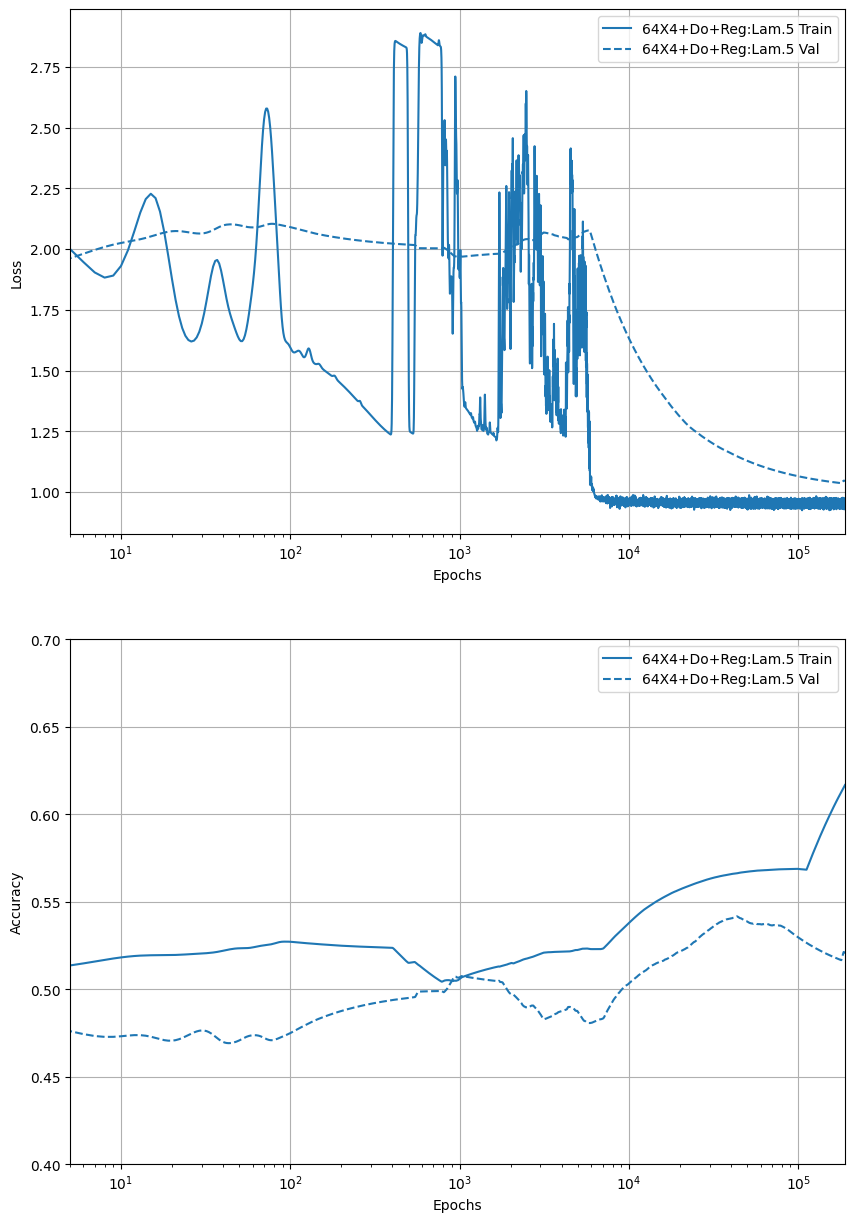

In [102]:
histories["64x4+DO+Reg:Lam.5"] = history

plt.rcParams['figure.figsize'] = [10, 15]

# PLOT histories
plt.subplot(211)
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10).plot(histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
#plt.ylim([0.75, 1.1])
plt.xlabel("Epochs")

plt.subplot(212)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10).plot(histories)
#plotter.plot(histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.4, 0.7])
plt.xlabel("Epochs")


In [220]:
tf.keras.metrics.Accuracy()(y_pred=roundTan(tf.nn.tanh(mlmodel(val_df_x))), y_true=val_df_y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.53>

In [103]:
mlutils.evaluate(ppl.onehot(toSigmoid(tf.nn.tanh(mlmodel(train_df_x))).numpy()), ppl.onehot(toSigmoid(train_df_y).numpy()), threshold=0.5)

Won : 682.0
Lost : 518.0
Total : 1200.0
Diff : 164.0
Edge : 13.666666666666666%
Information Coefficient : 0.1366666555404663


0.5683333

In [166]:
mlutils.evaluate(ppl.onehot(toSigmoid(tf.nn.tanh(mlmodel(val_df_x))).numpy()), ppl.onehot(toSigmoid(val_df_y).numpy()), threshold=0.5)

Won : 54.0
Lost : 46.0
Total : 100.0
Diff : 8.0
Edge : 8.0%
Information Coefficient : 0.08000004291534424


0.54

In [167]:
mlutils.evaluate(ppl.onehot(toSigmoid(tf.nn.tanh(mlmodel(test_df_x))).numpy()), ppl.onehot(toSigmoid(test_df_y).numpy()), threshold=0.5)

Won : 44.0
Lost : 43.0
Total : 87.0
Diff : 1.0
Edge : 1.1494252873563218%
Information Coefficient : 0.011494278907775879


0.50574714

In [92]:
tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_pred=mlmodel(val_x), y_true=toSigmoid(val_y))

<tf.Tensor: shape=(), dtype=float32, numpy=0.69271004>

In [91]:
tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_pred=baseline, y_true=toSigmoid(val_y))

<tf.Tensor: shape=(), dtype=float64, numpy=0.6941605066964598>

In [101]:
baseline = [np.sum(toSigmoid(train_y)==1)/len(train_y)]*len(test_y)

In [102]:
tf.keras.metrics.BinaryAccuracy()(y_pred=baseline, y_true=toSigmoid(test_y))

<tf.Tensor: shape=(), dtype=float32, numpy=0.43678162>

In [47]:
mlmodel.save("PossiblyAwesome_CNNx4+BN+DO+Batch40-ELU_model-IV")

INFO:tensorflow:Assets written to: PossiblyAwesome_CNNx4+BN+DO+Batch40-ELU_model-IV/assets


INFO:tensorflow:Assets written to: PossiblyAwesome_CNNx4+BN+DO+Batch40-ELU_model-IV/assets


In [222]:
modelName = "PossiblyAwesome_CNNx4+BN+DO+Batch40_model-I"
mlmodel = tf.keras.models.load_model(modelName)

Actual data ratio: 48.44% Positive, 51.56% Negative
Prediction data ratio: 19.97% Positive, 80.03% Negative

Classification Metrics

Won : 684
Lost : 658
Total : 1342
Diff : 26

Accuracy : 50.97%
Information Coefficient (Edge): 1.94%
Expected Value (Annualised): -7645.77%

Precision: Of all the predicted Buys/Sells, how many were correct?
Precision (Buy) : 48.51%
Precision (Sell): 51.58%

Recall: Of all the actual Buys/Sells, how many were correct?
Recall (Buy): 20.00%
Recall (Sell): 80.06%

F1 Score: Harmonic mean of Precision and Recall for the Buys/Sells
F1 Score (Buy): 28.32%
F1 Score (Sell): 62.74%


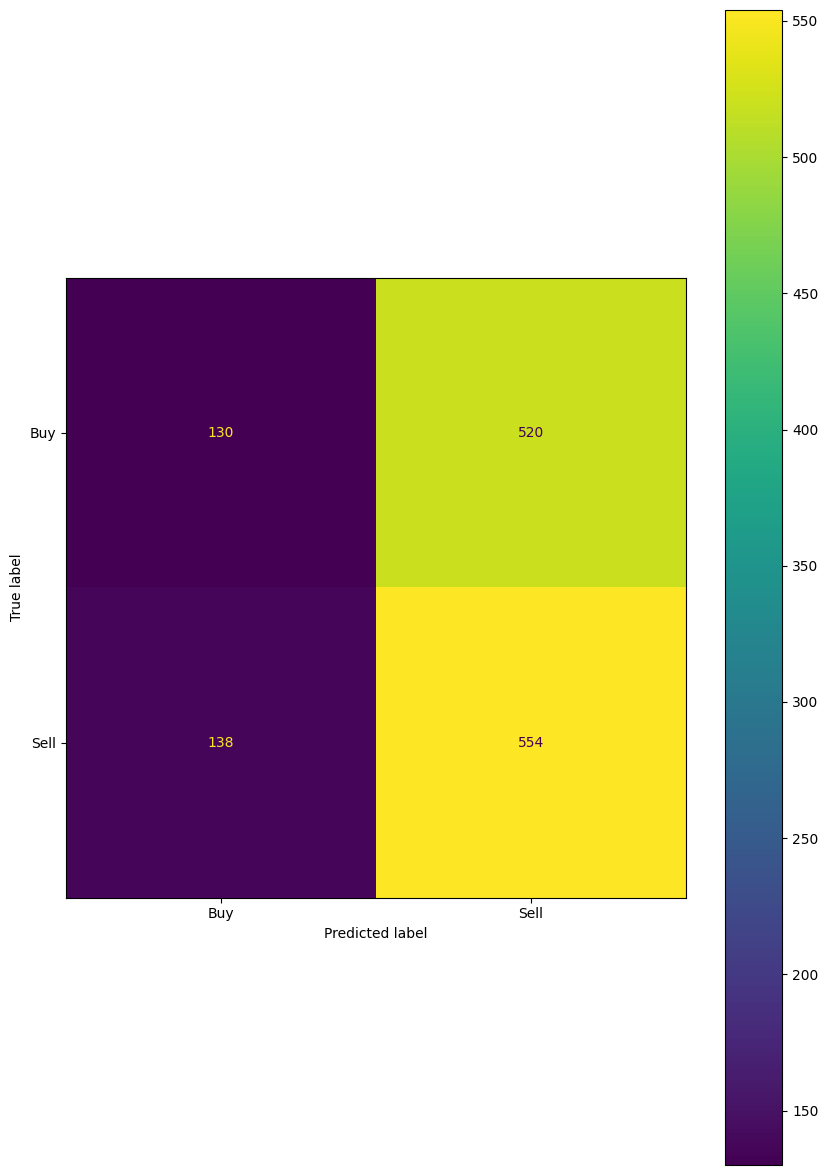

In [223]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

pred = pd.DataFrame(roundTan(tf.nn.tanh(mlmodel(all_x))).numpy().flatten(), index=dataset.index[1200:])
true = pd.DataFrame(all_y.numpy().flatten(), index=dataset.index[1200:])

print(f"Actual data ratio: {len(true.values[true>0])/len(true):.2%} Positive, {len(true.values[true<0])/len(true):.2%} Negative")
print(f"Prediction data ratio: {len(pred.values[pred>0])/len(pred):.2%} Positive, {len(pred.values[pred<0])/len(pred):.2%} Negative")

im = InsightManager(None)
im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"actual":true[0], "predictions":pred[0], "noHold":True, "returnsData":False}))
#im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"baseline":p.assets[0], "noHold":True}))

results = im.generateInsights()


In [224]:
pred.to_pickle(f"{modelName}-1.7(nonneg)-all.pkl")

Actual data ratio: 52.25% Positive, 47.75% Negative
Prediction data ratio: 73.25% Positive, 26.75% Negative

Classification Metrics

Won : 808
Lost : 392
Total : 1200
Diff : 416

Accuracy : 67.33%
Information Coefficient (Edge): 34.67%
Expected Value (Annualised): 16630.38%

Precision: Of all the predicted Buys/Sells, how many were correct?
Precision (Buy) : 63.37%
Precision (Sell): 78.19%

Recall: Of all the actual Buys/Sells, how many were correct?
Recall (Buy): 88.84%
Recall (Sell): 43.80%

F1 Score: Harmonic mean of Precision and Recall for the Buys/Sells
F1 Score (Buy): 73.97%
F1 Score (Sell): 56.15%


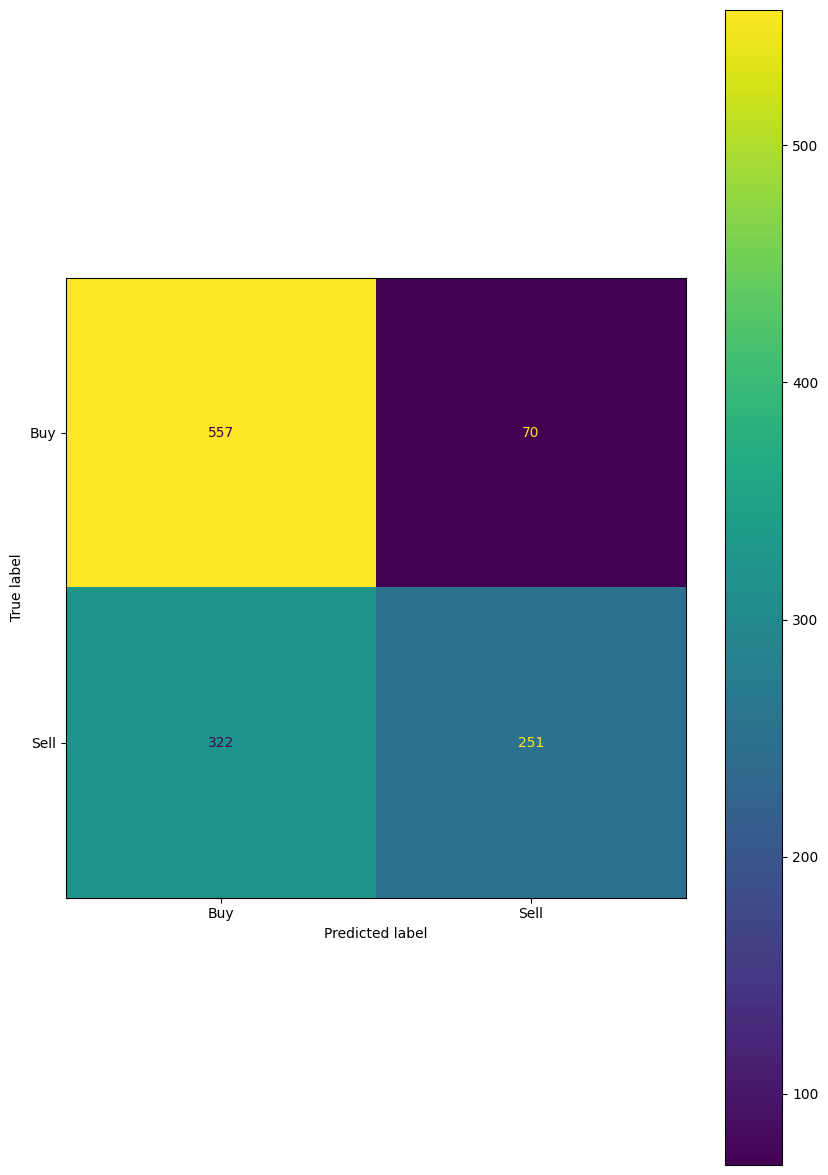

In [163]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

pred = pd.DataFrame(roundTan(tf.nn.tanh(mlmodel(train_df_x))).numpy().flatten(), index=dataset.index[:1200])
true = pd.DataFrame(train_df_y.numpy().flatten(), index=dataset.index[:1200])

print(f"Actual data ratio: {len(true.values[true>0])/len(true):.2%} Positive, {len(true.values[true<0])/len(true):.2%} Negative")
print(f"Prediction data ratio: {len(pred.values[pred>0])/len(pred):.2%} Positive, {len(pred.values[pred<0])/len(pred):.2%} Negative")

im = InsightManager(None)
im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"actual":true[0], "predictions":pred[0], "noHold":True, "returnsData":False}))
#im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"baseline":p.assets[0], "noHold":True}))

results = im.generateInsights()


Actual data ratio: 50.00% Positive, 50.00% Negative
Prediction data ratio: 67.00% Positive, 33.00% Negative

Classification Metrics

Won : 53
Lost : 47
Total : 100
Diff : 6

Accuracy : 53.00%
Information Coefficient (Edge): 6.00%
Expected Value (Annualised): 6430.02%

Precision: Of all the predicted Buys/Sells, how many were correct?
Precision (Buy) : 52.24%
Precision (Sell): 54.55%

Recall: Of all the actual Buys/Sells, how many were correct?
Recall (Buy): 70.00%
Recall (Sell): 36.00%

F1 Score: Harmonic mean of Precision and Recall for the Buys/Sells
F1 Score (Buy): 59.83%
F1 Score (Sell): 43.37%


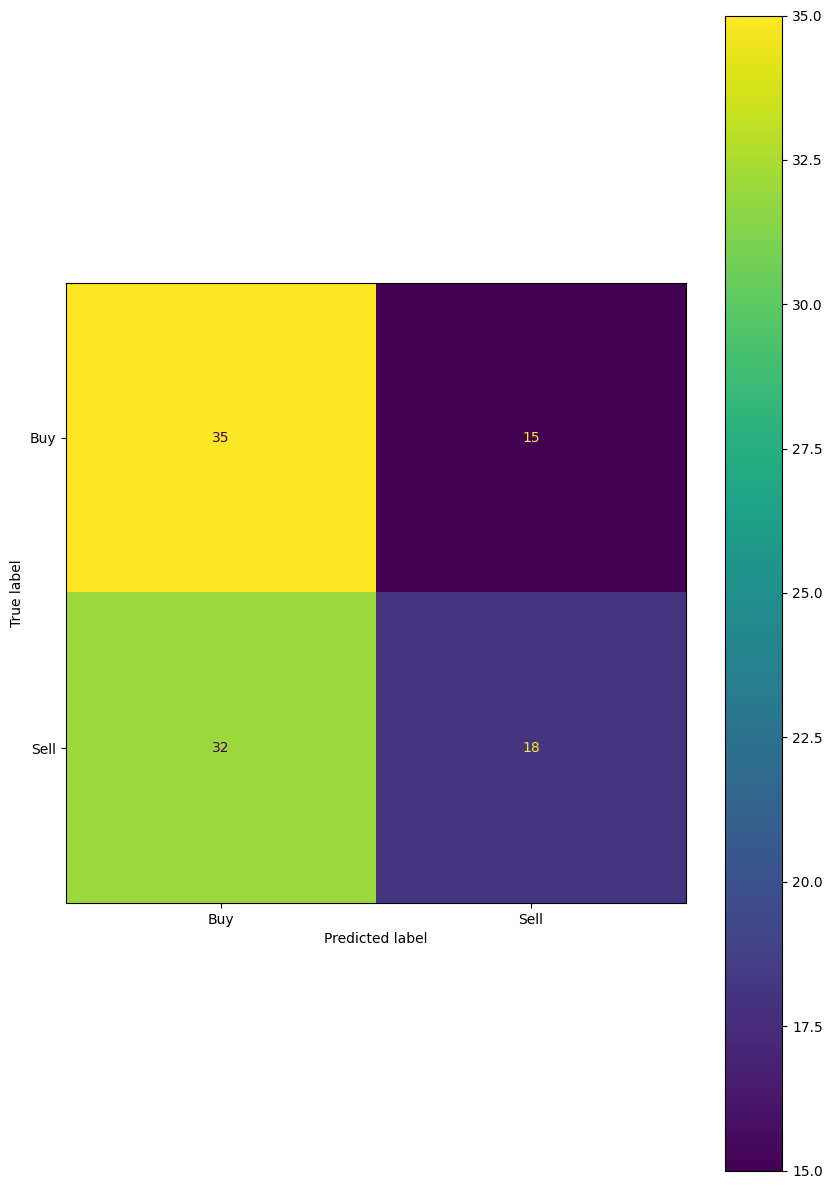

In [171]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

pred = pd.DataFrame(roundTan(tf.nn.tanh(mlmodel(val_df_x))).numpy().flatten(), index=dataset.index[1200:1300])
true = pd.DataFrame(val_df_y.numpy().flatten(), index=dataset.index[1200:1300])

print(f"Actual data ratio: {len(true.values[true>0])/len(true):.2%} Positive, {len(true.values[true<0])/len(true):.2%} Negative")
print(f"Prediction data ratio: {len(pred.values[pred>0])/len(pred):.2%} Positive, {len(pred.values[pred<0])/len(pred):.2%} Negative")

im = InsightManager(None)
im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"actual":true[0], "predictions":pred[0], "noHold":True, "returnsData":False}))
#im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"baseline":p.assets[0], "noHold":True}))

results = im.generateInsights()


Actual data ratio: 43.68% Positive, 56.32% Negative
Prediction data ratio: 60.92% Positive, 39.08% Negative

Classification Metrics

Won : 46
Lost : 41
Total : 87
Diff : 5

Accuracy : 52.87%
Information Coefficient (Edge): 5.75%
Expected Value (Annualised): 4690.83%

Precision: Of all the predicted Buys/Sells, how many were correct?
Precision (Buy) : 47.17%
Precision (Sell): 61.76%

Recall: Of all the actual Buys/Sells, how many were correct?
Recall (Buy): 65.79%
Recall (Sell): 42.86%

F1 Score: Harmonic mean of Precision and Recall for the Buys/Sells
F1 Score (Buy): 54.95%
F1 Score (Sell): 50.60%


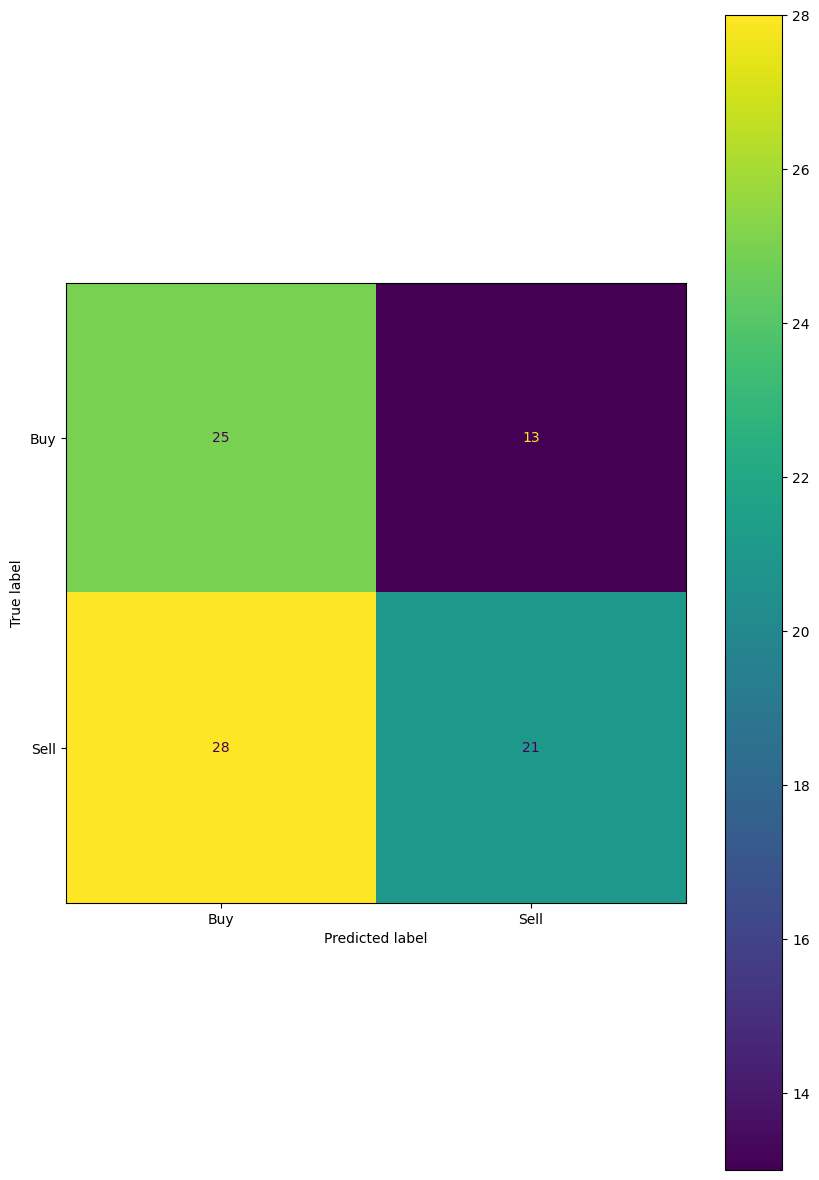

In [173]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

pred = pd.DataFrame(roundTan(tf.nn.tanh(mlmodel(test_df_x))).numpy().flatten(), index=dataset.index[1300:])
true = pd.DataFrame(test_df_y.numpy().flatten(), index=dataset.index[1300:])

print(f"Actual data ratio: {len(true.values[true>0])/len(true):.2%} Positive, {len(true.values[true<0])/len(true):.2%} Negative")
print(f"Prediction data ratio: {len(pred.values[pred>0])/len(pred):.2%} Positive, {len(pred.values[pred<0])/len(pred):.2%} Negative")

im = InsightManager(None)
im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"actual":true[0], "predictions":pred[0], "noHold":True, "returnsData":False}))
#im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"baseline":p.assets[0], "noHold":True}))

results = im.generateInsights()


In [225]:
true.to_pickle("results-all.pkl")